In [38]:
import os
import cv2
import random
import numpy as np

from matplotlib import pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet
from skimage.io import imread

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [35]:
def showRandomPredict(images, masks, predicts, sample_count, if_predicted= False):
    sample_count = sample_count * 4
    plt.figure(figsize=(15, 30))
    for i in range(0, sample_count, 4):
        img_index = random.choice(range(len(images)))
        plt.subplot(5,4,i + 1)
        random_img = images[img_index,:,:]
        random_img = cv2.resize(random_img, (IMG_HEIGHT, IMG_WIDTH))
        plt.imshow(random_img, cmap=plt.cm.bone)
        plt.axis('off')
        plt.title('Lung X-Ray')

        plt.subplot(5,4,i + 2)
        random_mask = masks[img_index,:,:]
        random_mask = cv2.resize(random_mask, (IMG_HEIGHT, IMG_WIDTH))
        plt.imshow(random_mask, cmap='gray')
        plt.axis('off')
        plt.title('Mask Ground Truth')
        
        if not if_predicted:
            continue
        random_pred = predicts[img_index,:,:,0]
        plt.subplot(5,4,i + 3)
        plt.imshow(random_pred, cmap='gray')
        plt.axis('off')
        plt.title('Predicted Mask')

        plt.subplot(5,4,i + 4)
        plt.imshow(cv2.bitwise_and(images[img_index,:,:], images[img_index,:,:], mask=random_pred.astype(np.uint8)), cmap=plt.cm.bone)
        plt.axis('off')
        plt.title('Predicted Lung Segmentation')
    plt.show()

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

image_path = "C:\\Users\\ugur_\\Python Projects\\DATA\\Lung Segmentation\\CXR_png\\"
mask_path = "C:\\Users\\ugur_\\Python Projects\\DATA\Lung Segmentation\\masks\\"

images = os.listdir(image_path)
mask = os.listdir(mask_path)

print(len(images), len(mask))

800 704


In [4]:
mask2 = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask2]
print(len(image_file_name), len(mask))

704 704


In [5]:
check = [i for i in mask if "mask" in i]
print(len(check))

566


In [6]:
x = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))
y = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))

for i, img_id in enumerate(image_file_name):
    
    file_path = image_path  + img_id + ".png"
    
    # read the file as an array
    cv2_image = cv2.imread(file_path, 0)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('img.jpg', cv2_image)
    
    # read the image using skimage
    img = imread('img.jpg')
    x[i] = img
    
    os.remove('img.jpg')

    
for i, img_id in enumerate(mask):
    
    file_path = mask_path  + img_id 
    
    # read the file as an array
    cv2_image = cv2.imread(file_path, 0)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('img.jpg', cv2_image)
    
    # read the image using skimage
    img = imread('img.jpg')
    y[i] = img
    
    os.remove('img.jpg')

In [7]:
X_train, X_test, y_train_m, y_test_m = train_test_split(x, y, test_size=0.2, random_state=123)

x2 = np.flip(X_train , axis = 2)
y2 = np.flip(y_train_m , axis = 2)

X_train= np.append(X_train, x2,axis=0)
y_train_m = np.append(y_train_m, y2,axis=0)

(1126, 128, 128) (1126, 128, 128)


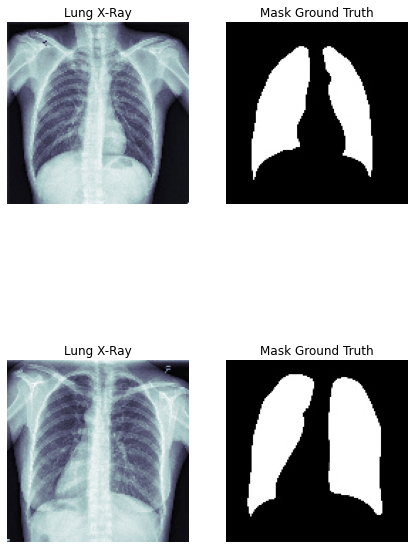

In [34]:
print(X_train.shape,y_train_m.shape)
showRandomPredict(X_train, y_train_m, y_train_m, 2)

In [9]:
model = custom_unet(
    (128, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),]

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'],)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
y_test_m2 = (y_test_m/255.> .5).astype(int)
y_train_m2 = (y_train_m/255.> .5).astype(int)

In [12]:
h = model.fit(
    X_train/255., y_train_m2,   
    callbacks=callbacks,
    validation_data=(X_test/255., y_test_m2),
    epochs=15, batch_size=20,
)

Epoch 1/15
57/57 [==============================] - 48s 527ms/step - loss: 0.3117 - accuracy: 0.8632 - val_loss: 9.0873 - val_accuracy: 0.3701

Epoch 00001: val_accuracy improved from -inf to 0.37014, saving model to model.h5
Epoch 2/15
57/57 [==============================] - 10s 168ms/step - loss: 0.0760 - accuracy: 0.9760 - val_loss: 1.0316 - val_accuracy: 0.8902

Epoch 00002: val_accuracy improved from 0.37014 to 0.89022, saving model to model.h5
Epoch 3/15
57/57 [==============================] - 10s 172ms/step - loss: 0.0659 - accuracy: 0.9773 - val_loss: 0.2449 - val_accuracy: 0.9515

Epoch 00003: val_accuracy improved from 0.89022 to 0.95146, saving model to model.h5
Epoch 4/15
57/57 [==============================] - 10s 177ms/step - loss: 0.0620 - accuracy: 0.9781 - val_loss: 0.0999 - val_accuracy: 0.9632

Epoch 00004: val_accuracy improved from 0.95146 to 0.96323, saving model to model.h5
Epoch 5/15
57/57 [==============================] - 10s 175ms/step - loss: 0.0597 - acc

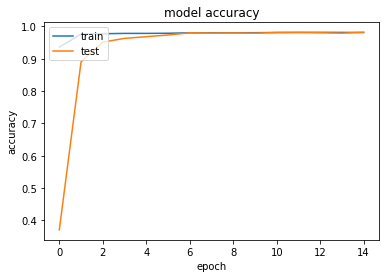

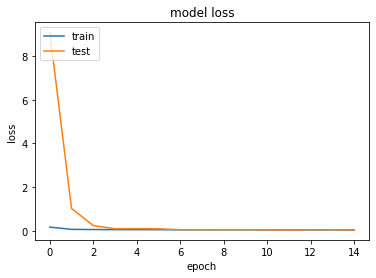

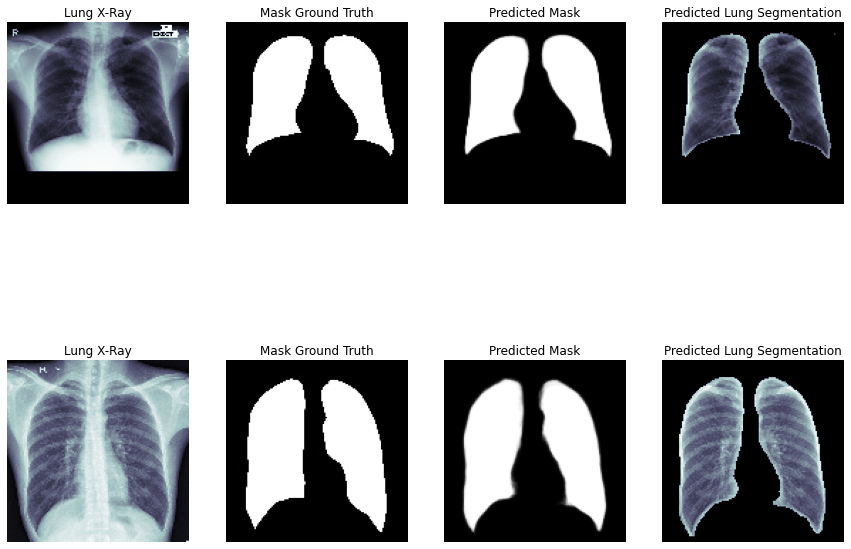

In [37]:
model = load_model("model.h5")

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

preds = model.predict(X_test/255.)*255
showRandomPredict(X_test, y_test_m, preds, 2, True)

In [23]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
]

In [17]:
h2 = model.fit(
    X_train/255., y_train_m2,
    validation_data=(X_test/255., y_test_m2),
    epochs=50, batch_size=16,
    shuffle=True,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/50
71/71 - 25s - loss: 0.0455 - accuracy: 0.9823 - val_loss: 0.0584 - val_accuracy: 0.9807

Epoch 00001: val_accuracy improved from -inf to 0.98066, saving model to model.h5
Epoch 2/50
71/71 - 8s - loss: 0.0490 - accuracy: 0.9813 - val_loss: 0.0573 - val_accuracy: 0.9804

Epoch 00002: val_accuracy did not improve from 0.98066
Epoch 3/50
71/71 - 9s - loss: 0.0455 - accuracy: 0.9822 - val_loss: 0.0650 - val_accuracy: 0.9772

Epoch 00003: val_accuracy did not improve from 0.98066
Epoch 4/50
71/71 - 9s - loss: 0.0442 - accuracy: 0.9825 - val_loss: 0.0511 - val_accuracy: 0.9815

Epoch 00004: val_accuracy improved from 0.98066 to 0.98153, saving model to model.h5
Epoch 5/50
71/71 - 9s - loss: 0.0442 - accuracy: 0.9826 - val_loss: 0.0483 - val_accuracy: 0.9813

Epoch 00005: val_accuracy did not improve from 0.98153
Epoch 6/50
71/71 - 9s - loss: 0.0425 - accuracy: 0.9832 - val_loss: 0.0526 - val_accuracy: 0.9821

Epoch 00006: val_accuracy improved from 0.98153 to 0.98215, saving model 

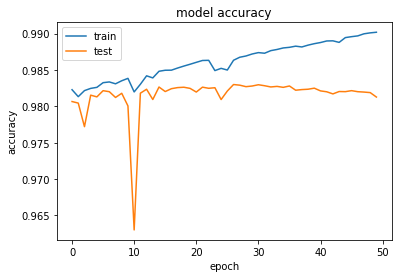

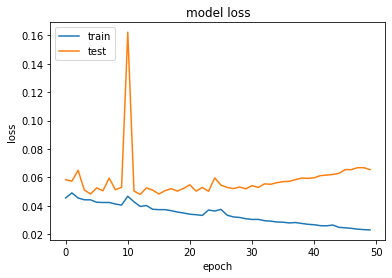

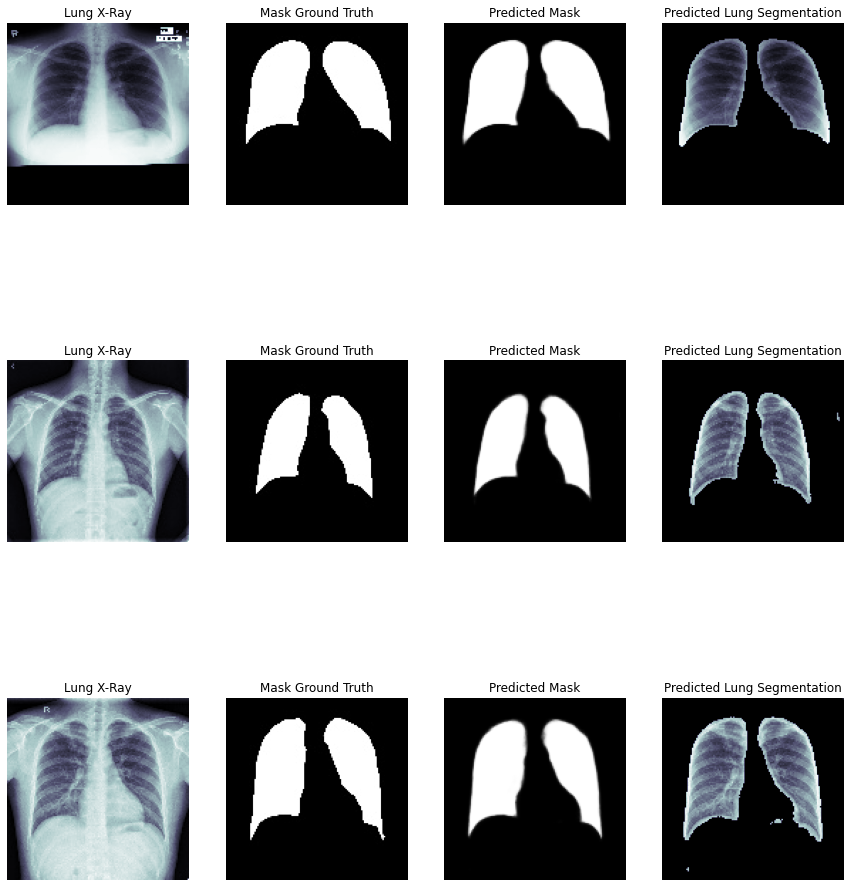

In [43]:
model = load_model('model.h5')

plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h2.history['loss']
accs = h2.history['accuracy']
val_losses = h2.history['val_loss']
val_accs = h2.history['val_accuracy']
epochs = len(losses)
showRandomPredict(X_test, y_test_m, preds, 3, True)